In [1]:
!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn

In [2]:
import fiftyone as fo

In [4]:
dataset = fo.Dataset.from_dir(
    data_path="/home/jovyan/work/data/",
    labels_path="/home/jovyan/work/output_11-8/leaves_val.json",
    dataset_type=fo.types.COCODetectionDataset, 
    name="val_11-8_11-15",
    label_types="segmentations"
)


 100% |███████████████████| 39/39 [8.1s elapsed, 0s remaining, 5.6 samples/s]       


In [ ]:
print(dataset)

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms

In [6]:
base_path = "/home/jovyan/work/output_11-8/"

leaf_cfg = get_cfg()
leaf_cfg.MODEL.DEVICE='cpu'
leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

leaf_predictor = DefaultPredictor(leaf_cfg)

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

[11/15 17:03:36 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [7]:
from IPython.display import display


In [101]:


with fo.ProgressBar() as pb:
    for sample in pb(dataset):

        # run interence on selected image
        image = Image.open(sample.filepath)
        image = ImageOps.exif_transpose(image)
        
        image_arr = np.array(image)
        h, w, c = image_arr.shape
        print (h,w,c)
        outputs = leaf_predictor(image_arr)
        
        # get bboxes and class labels
        pred_boxes = outputs["instances"].pred_boxes.tensor.numpy()
        pred_masks = outputs["instances"].pred_masks.numpy()
        class_labels = outputs["instances"].pred_classes.numpy()
        scores = outputs["instances"].scores.numpy()
        
        # track indicies of 
        qr_indices = []
        leaf_indices = []
        red_square_indices = []
        
        # get indices of leaves and qr codes
        for i, label in enumerate(class_labels):
            if label == 0: # leaf
                leaf_indices.append(i)
            elif label == 1: # qr
                qr_indices.append(i)
            elif label == 2: # red-square
                red_square_indices.append(i)
                
        classes = ['leaf', 'qr', 'red-square']
        
        detections = []
        
        # track pixel 
        red_square_pixels = 0
        leaf_pixels = 0
        qr_pixels = 0
        
        for label, mask, box, score in zip(class_labels, pred_masks, pred_boxes, scores):
           
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
            
            bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
            mask_h, mask_w = bbox_mask.shape
            
            mask_pixel_count = np.count_nonzero(mask)
            class_label = classes[label]
            
            # print('label: ', class_label)
            # print('mask_pixel_count: ', mask_pixel_count)
            
            if class_label == 'leaf':
                leaf_pixels += mask_pixel_count
            elif class_label == 'red-square':
                red_square_pixels = mask_pixel_count
            elif class_label == 'qr':
                qr_pixels = mask_pixel_count

            
            
            # print(mask.shape)
            # print(np.count_nonzero(mask))
            
            # print(rel_box)
            
            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                )
            )
        
        
        print('image: ', sample.filepath)
        print('red_square_pixels: ', red_square_pixels)
        print('leaf_pixels: ', leaf_pixels)
        print('qr_pixels: ', qr_pixels)
        
        leaf_area = None
        
        if red_square_pixels:
            leaf_area = (4 * leaf_pixels) / red_square_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        elif qr_pixels:
            leaf_area = (1.44 * leaf_pixels) / qr_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        
        sample["predictions"] = fo.Detections(detections=detections)
        sample["height"] = h
        sample["width"] = w
        sample["area"] = leaf_area
        
        sample.save()


        

4640 6960 3                                                                  
image:  /home/jovyan/work/data/leaves/new_batch/IMG_6147.JPG
red_square_pixels:  660850
leaf_pixels:  2849747
qr_pixels:  539165
leaf area: 17.248979344783233 cm2
4640 6960 3                                                                     
image:  /home/jovyan/work/data/leaves/new_batch/IMG_6036.JPG
red_square_pixels:  1186267
leaf_pixels:  2420444
qr_pixels:  316508
leaf area: 8.161548791292349 cm2
4640 6960 3                                                                     
image:  /home/jovyan/work/data/leaves/new_batch/IMG_5978.JPG
red_square_pixels:  1131702
leaf_pixels:  6765
qr_pixels:  323614
leaf area: 0.023910888202017845 cm2
6960 4640 3                                                                     
image:  /home/jovyan/work/data/leaves/new_batch/IMG_5907.JPG
red_square_pixels:  1071964
leaf_pixels:  151522
qr_pixels:  308051
leaf area: 0.5653995843143986 cm2
4640 6960 3                

In [17]:
print(dataset.last())
!pip install openpyxl

<Sample: {
    'id': '6373c65e38bce5e4a31cc173',
    'media_type': 'image',
    'filepath': '/home/jovyan/work/data/leaves/IMG_5793.JPG',
    'tags': [],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 6960,
        'height': 4640,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '6373c65e38bce5e4a31cc16e',
                'attributes': {},
                'tags': [],
                'label': 'leaf',
                'bounding_box': [
                    0.5211010060403429,
                    0.42541281341268655,
                    0.00929065560481366,
                    0.020472930504730525,
                ],
                'mask': array([[False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
 

In [102]:
import pandas as pd

df = pd.read_excel('/home/jovyan/work/First_batch_area.xlsx')
df['ml_area'] = None
df['ml_area'] = df['ml_area'].astype(float)
print(df)


          picture  area_cm2  ml_area
0    IMG_5792.tif      0.16      NaN
1    IMG_5793.tif      0.07      NaN
2    IMG_5794.tif      0.37      NaN
3    IMG_5795.tif      0.09      NaN
4    IMG_5849.tif      0.66      NaN
..            ...       ...      ...
174  IMG_6055.tif      4.70      NaN
175  IMG_6056.tif     16.53      NaN
176  IMG_6057.tif      0.83      NaN
177  IMG_6058.tif      0.55      NaN
178  IMG_6059.tif      4.95      NaN

[179 rows x 3 columns]


In [110]:
missing = []

for sample in dataset:

    filename = sample.filepath.split('/')[-1].split('.')[0]
    print(filename)
    print(sample.area)
    
    if not df.loc[df['picture'].str.startswith(filename)].empty:
        df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2)) 
    else:
        missing.append(filename)

print(df)
print(missing)


    

IMG_6147
17.248979344783233
IMG_6036
8.161548791292349
IMG_5978
0.023910888202017845
IMG_5907
0.5653995843143986
IMG_5868
0.0
IMG_5918
0.20000937750813866
IMG_5916
0.37871403496352446
IMG_5878
0.0
IMG_6149
5.680640509820422
IMG_6158
0.225581436746582
IMG_6160
0.012479109398650495
IMG_5957
0.24921267010742298
IMG_5956
9.043627465176218
IMG_6055
4.063131238249999
IMG_6047
3.3177375081729887
IMG_6043
0.09757390602639662
IMG_6042
0.6258244842686256
IMG_6037
0.6671186259099865
IMG_6035
10.491237158484651
IMG_6034
0.7847532076531817
IMG_6032
0.1460024717338615
IMG_6031
0.6722383873677025
IMG_6026
1.7988620360763865
IMG_6018
9.427043175104242
IMG_5970
2.5782843530550292
IMG_5860
0.1394279609759163
IMG_5858
0.0
IMG_5924
0.226788058190742
IMG_5994
4.009679041017326
IMG_5992
0.33769478944815806
IMG_5991
2.2532960825356234
IMG_5990
1.8808873902570038
IMG_5988
0.464204351292858
IMG_5942
0.07438968572270184
IMG_5856
0.6606476863028705
IMG_5979
0.3262966265350939
IMG_5915
0.25298246802031105
IMG_590

In [111]:
df_area = df[df['ml_area'] >= 0.0]
print(df_area)
df.dtypes

          picture  area_cm2  ml_area
1    IMG_5793.tif      0.07     0.05
11   IMG_5856.tif      0.52     0.66
13   IMG_5858.tif      0.12     0.00
15   IMG_5860.tif      0.15     0.14
21   IMG_5868.tif      0.04     0.00
31   IMG_5878.tif      0.03     0.00
33   IMG_5905.tif      7.33     7.03
35   IMG_5907.tif      0.60     0.57
42   IMG_5915.tif      0.31     0.25
43   IMG_5916.tif      0.46     0.38
45   IMG_5918.tif      0.36     0.20
51   IMG_5924.tif      0.25     0.23
69   IMG_5942.tif      0.09     0.07
83   IMG_5956.tif     10.17     9.04
84   IMG_5957.tif      0.28     0.25
96   IMG_5970.tif      2.70     2.58
104  IMG_5978.tif      0.12     0.02
105  IMG_5979.tif      0.42     0.33
112  IMG_5988.tif      0.51     0.46
114  IMG_5990.tif      1.97     1.88
115  IMG_5991.tif      2.37     2.25
116  IMG_5992.tif      0.36     0.34
118  IMG_5994.tif      4.21     4.01
140  IMG_6018.tif      7.97     9.43
148  IMG_6026.tif      1.55     1.80
153  IMG_6031.tif      0.81     0.67
1

picture      object
area_cm2    float64
ml_area     float64
dtype: object

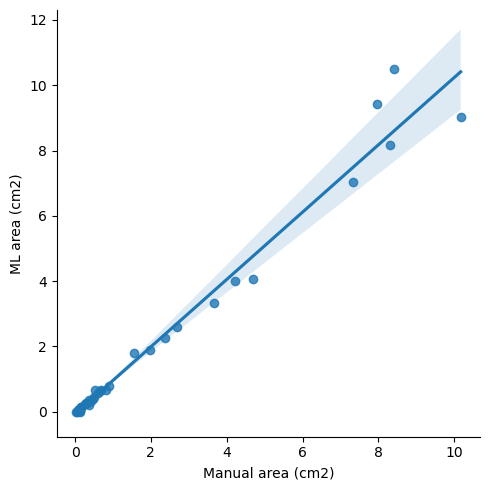

In [118]:
import seaborn as sns
plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
plt.set(xlabel='Manual area (cm2)', ylabel='ML area (cm2)')

In [95]:
df_area.corr()

,area_cm2,ml_area
area_cm2,1.000000,0.986189
ml_area,0.986189,1.000000


In [133]:
from scipy import stats

corr = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print(corr)
r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

PearsonRResult(statistic=0.9867694332421145, pvalue=1.1757664792264736e-27)
r^2: 0.9737139143809639


In [114]:
df_area.corr(method='pearson')

,area_cm2,ml_area
area_cm2,1.000000,0.986769
ml_area,0.986769,1.000000


In [115]:
df_area.corr(method='kendall')

,area_cm2,ml_area
area_cm2,1.00000,0.94924
ml_area,0.94924,1.00000


In [181]:
count = 0

for i in range(0, 1000):
    df_area_permutation = df_area.copy()
    
    # permute ml_area column
    # df_area_permutation['area_cm2'] = np.random.permutation(df_area_permutation['area_cm2'])
    df_area_permutation['ml_area'] = np.random.permutation(df_area_permutation['ml_area'])
    # print(df_area_permutation)
    
    # get r^2 value for permutation
    permutation_corr = stats.pearsonr(df_area_permutation.area_cm2, df_area_permutation.ml_area)
    permutation_r_squared = permutation_corr.statistic * permutation_corr.statistic
    # print(permutation_corr)
    # print(permutation_r_squared)
    
    if permutation_r_squared > r_squared:
        count += 1

print(count)
    
    
    
    
    
    

0


In [167]:
session = fo.launch_app(dataset, port=5151, address="0.0.0.0")

In [ ]:
session.refresh()

In [ ]:
import matplotlib.pyplot as plt
# [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

def convert_to_pixels(fo_format, h, w):
    x1, y1, x2, y2 = fo_format
    return [x1 * w, y1 * h, (w * x2) + (x1 * w), (h * y2) + (y1 * h)]

In [ ]:
sample_ious = []
sample_dice = []

# sample = dataset.last()
for sample in dataset:
    
    print('\n --------------------------------------------------------------')
    print('\nSample: ', sample.filepath)

    # ------- get bboxes & masks for GROUND TRUTH and PREDICTIONS ------ #

    ground_truth_detections = sample.ground_truth.detections
    prediction_detections = sample.predictions.detections

    height = sample.height
    width  = sample.width

    ground_truth_bboxes = []
    ground_truth_masks = []

    prediction_bboxes = []
    prediction_masks = []
    detectron2_bboxes = []


    # get bboxes and masks from ground truth
    for d in ground_truth_detections:
        if (d.label == 'leaf'):
            ground_truth_bboxes.append(d.bounding_box)
            ground_truth_masks.append(d.mask)

    # get bboxes and masks from predictions
    for d in prediction_detections:
        if (d.label == 'leaf'):
            prediction_bboxes.append(d.bounding_box)
            prediction_masks.append(d.mask)
            detectron2_bboxes.append(d.original_bbox)



    # ---------- assemble PREDICTION mask for entire photo ------------ #
    complete_prediction_mask = np.zeros((height, width))


    for index, bbox in enumerate(prediction_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)], prediction_masks[index])

    print('Prediction pixel count: ', np.count_nonzero(complete_prediction_mask))



    # --------- assemble GROUND TRUTH mask for entire photo ----------- #
    complete_ground_truth_mask = np.zeros((height, width))

    for index, bbox in enumerate(ground_truth_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)], ground_truth_masks[index])

    print('Ground truth pixel count: ', np.count_nonzero(complete_ground_truth_mask))
    
    
     # ------- calculate Intersection Over Union (Jaccard Index) ------- #

    intersect = np.logical_and(complete_ground_truth_mask, complete_prediction_mask)
    union = np.logical_or(complete_ground_truth_mask, complete_prediction_mask)

    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    iou = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        iou = intersect_pixels / union_pixels

    print('IOU:', iou)
    sample_ious.append(iou)
    
    # ------------ calculate Dice Coefficient (F1 Score) -------------- #
    
    dice = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        dice = (2 * intersect_pixels) / (np.count_nonzero(complete_ground_truth_mask) + np.count_nonzero(complete_prediction_mask))

    print('Dice:', dice)
    sample_dice.append(dice)

    # --------- visualize GROUND TRUTH and PREDICTION masks ----------- #
    f, axarr = plt.subplots(1,2)
    plt.rcParams['figure.figsize'] = [10, 10]

    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')

    axarr[0].imshow(complete_ground_truth_mask)
    axarr[1].imshow(complete_prediction_mask)
    
    display(f)
 

In [ ]:
print(sample_ious)

sample_ious = np.array(sample_ious, dtype=np.float)

print(sample_ious)

# sample_ious[sample_ious == None] = np.nan

print('Min IOU: ', np.nanmin(sample_ious))
print('Max IOU: ', np.nanmax(sample_ious))
print('Average IOU: ', np.nanmean(sample_ious))

print('\n')
# sample_dice[sample_dice == None] = np.nan

sample_dice = np.array(sample_dice, dtype=np.float)

print('Min Dice: ', np.nanmin(sample_dice))
print('Max Dice: ', np.nanmax(sample_dice))
print('Average Dice: ', np.nanmean(sample_dice))



